# Practical Exercise: GAN on Lego Brick Images

## 1. Understanding the Dataset

In [1]:
!pip install kaggle
!kaggle datasets download -d joosthazelzet/lego-brick-images --unzip

Dataset URL: https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images
License(s): GPL-2.0
100% 0.99G/1.00G [00:26<00:00, 41.2MB/s]
100% 1.00G/1.00G [00:26<00:00, 40.4MB/s]


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# --------------------
#   Hyperparameters
# --------------------
IMAGE_SIZE = 64       # Input/Output resolution
CHANNELS = 1          # Grayscale = 1, for color use 3
BATCH_SIZE = 128
Z_DIM = 100           # Dim of latent vector
EPOCHS = 1 # Just to see that the training is working
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NOISE_PARAM = 0.1     # Label smoothing/noise

# --------------------
#   Transforms
# --------------------
# Define the transforms: Grayscale + Resize + Normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Grayscale
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Center around 0 with range [-1,1]
])

In [4]:
# --------------------
# Dataset & DataLoader
#--------------------

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Gather all image files with .png, .jpg, .jpeg
        self.image_files = sorted([
            f for f in os.listdir(root_dir)
            if f.endswith(('.png', '.jpg', '.jpeg'))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")  # or "L" for grayscale
        if self.transform:
            image = self.transform(image)
        return image

# Specify your dataset folder path
dataset_path = 'dataset'
dataset = ImageDataset(root_dir=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

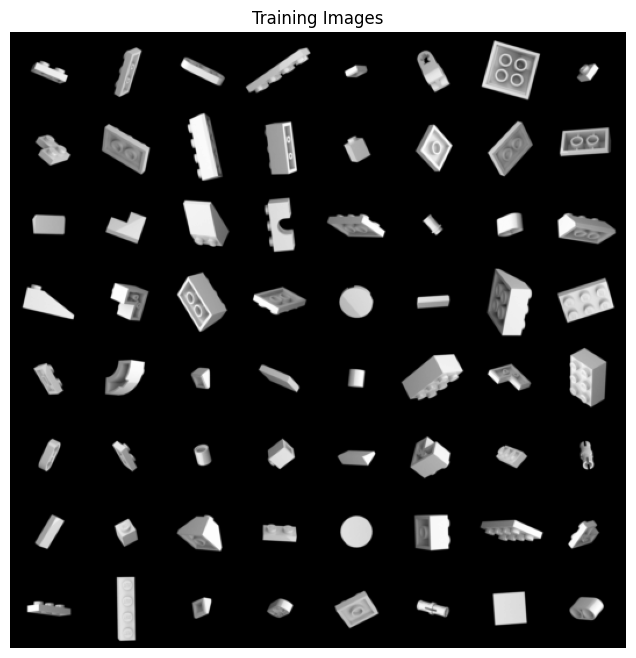

In [5]:
def plot_sample_images(loader):
    real_batch = next(iter(loader))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[:64], padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()
    plt.close()

plot_sample_images(dataloader)

## 2. Building the GAN Architecture

In [6]:
# ------------------------------
#   Discriminator
# ------------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input shape: (CHANNELS, 64, 64)
            nn.Conv2d(CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # activation function
            nn.Dropout(0.3), #dropout

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),# conv
            nn.BatchNorm2d(128), #batch norm
            nn.LeakyReLU(0.2, inplace=True), # activation function
            nn.Dropout(0.3), #dropout

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3), # dropout

            # Output shape: (1, 1, 1) -> Flatten to scalar
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),# activation function [0,1]
            nn.Flatten(start_dim=1) # Flatten shape: (batch_size, 1)
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# ------------------------------
#   Generator
# ------------------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: (Z_DIM, 1, 1)
            nn.ConvTranspose2d(Z_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), #norm
            nn.LeakyReLU(0.2, inplace=True), #activatio

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh() # activation function [-1,1]
            # Output shape: (CHANNELS, 64, 64)
        )

    def forward(self, x):
        return self.model(x)

In [8]:
# Instantiate models
critic = Discriminator().to(DEVICE)
generator = Generator().to(DEVICE)

In [9]:
# Test dimension consistency
x_sample = torch.randn(1, 1, 64, 64)
model_test = Discriminator()
output = model_test(x_sample)
assert output.shape == (1, 1), "Output dimensions do not match input dimensions!"

In [10]:
# Test dimension consistency
x_sample = torch.randn(1, 100, 1, 1)
model_test = Generator()
output = model_test(x_sample)
assert output.shape == (1, 1, 64, 64), "Output dimensions do not match input dimensions!"

## 3. Training Setup

In [18]:
#------------------------
#  Losses & Optimizers
#------------------------
criterion = nn.BCELoss()  # Binary Cross Entropy
d_optimizer = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

#------------------------
# Training
#------------------------

def train_model():
  g_loss_values = []
  d_loss_values = []
  g_acc_values = []
  d_acc_values = []

  for epoch in range(EPOCHS):
      g_loss_batch = []
      d_loss_batch = []
      g_acc_batch = []
      d_acc_batch = []

      progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{EPOCHS}")
      for i, real_images in progress_bar:
          real_images = real_images.to(DEVICE)
          batch_size = real_images.size(0)
          # 1) Train Discriminator
          critic.train()

          # True labels near 1, with some noise
          real_labels = torch.ones(batch_size, 1, device=DEVICE)
          real_noisy_labels = real_labels - NOISE_PARAM * torch.rand_like(real_labels)
          # Fake labels near 0, with some noise
          fake_labels = torch.zeros(batch_size, 1, device=DEVICE)
          fake_noisy_labels = fake_labels + NOISE_PARAM * torch.rand_like(fake_labels)

          # Real images
          real_preds = critic(real_images)
          real_loss = criterion(real_preds, real_noisy_labels) #get loss

          # Fake images
          z = torch.randn(batch_size, Z_DIM, 1, 1, device=DEVICE)
          fake_images = generator(z)
          fake_preds = critic(fake_images.detach())
          fake_loss = criterion(fake_preds, fake_noisy_labels)

          d_loss = (real_loss + fake_loss) / 2
          d_loss.backward()
          d_optimizer.step()

          # Compute discriminator accuracy
          d_real_acc = (real_preds.round() == real_labels).float().mean().item()
          d_fake_acc = (fake_preds.round() == fake_labels).float().mean().item()
          d_acc = (d_real_acc + d_fake_acc) / 2

          # 2) Train Generator
          generator.train()
          fake_preds = critic(fake_images)  # do not detach here
          # Generator wants D to say "real" => label=1
          g_loss = criterion(fake_preds, real_labels)
          g_loss.backward()
          g_optimizer.step()

          g_acc = (fake_preds.round() == real_labels).float().mean().item()

          # Track batch losses & accuracy
          d_loss_batch.append(d_loss.item())
          g_loss_batch.append(g_loss.item())
          d_acc_batch.append(d_acc)
          g_acc_batch.append(g_acc)

          progress_bar.set_postfix(D_Loss=d_loss.item(), G_Loss=g_loss.item())

      # End of epoch: record average metrics
      d_loss_values.append(np.mean(d_loss_batch))
      g_loss_values.append(np.mean(g_loss_batch))
      d_acc_values.append(np.mean(d_acc_batch))
      g_acc_values.append(np.mean(g_acc_batch))

      # Occasionally save sample images
      if (epoch + 1) % 10 == 0:
          # Generate sample images
          with torch.no_grad():
              z_sample = torch.randn(16, Z_DIM, 1, 1, device=DEVICE)
              fake_sample = generator(z_sample).cpu()
          # Save or display using torchvision.utils
          vutils.save_image(fake_sample, f"fake_sample_epoch_{epoch+1:03d}.png", normalize=True)

  return g_loss_values, d_loss_values, g_acc_values, d_acc_values

In [22]:
g_loss_values, d_loss_values, g_acc_values, d_acc_values = train_model()

Epoch 1/1: 100%|██████████| 313/313 [02:43<00:00,  1.91it/s, D_Loss=0.285, G_Loss=1.93]


For the rest of the notebook, we will be using the allready trained models from the professor

In [ ]:
!unzip models.zip

In [ ]:
critic = Discriminator().to(DEVICE)
critic.load_state_dict(torch.load("1_simple_discriminator.pth", weights_only=True))

<All keys matched successfully>

In [ ]:
generator = Generator().to(DEVICE)
generator.load_state_dict(torch.load("1_simple_generator.pth", weights_only=True))

<All keys matched successfully>

## 5. Monitoring Progress

In [ ]:
#--------------------------
#  Plotting Results
#--------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

titles = ['epoch_g_loss', 'epoch_g_acc', 'epoch_d_loss', 'epoch_d_acc']
data = [g_loss_values, g_acc_values, d_loss_values, d_acc_values]

for ax, title, values in zip(axes, titles, data):
    ax.plot(values, color='brown')
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

## 6. Generating and Evaluating

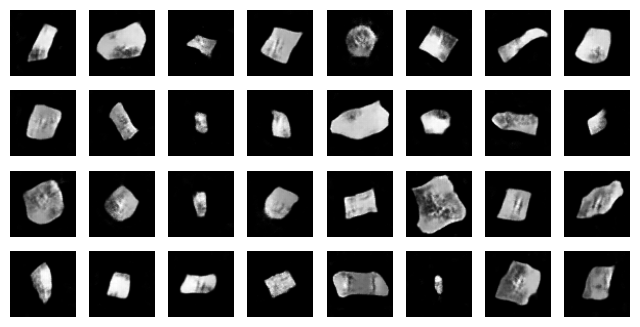

In [26]:
#--------------------------
#  Sampling
#--------------------------
# Generate a grid of images from random noise
grid_width, grid_height = (8, 4)
z_sample = torch.randn(grid_width * grid_height, Z_DIM, 1, 1, device=DEVICE)
gen_imgs = generator(z_sample).cpu().detach()

# Show them in a matplotlib grid
fig = plt.figure(figsize=(grid_width, grid_height))
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    # Each image shape: (1, 64, 64)
    ax.imshow(gen_imgs[i, 0, :, :], cmap="gray")
plt.show()